## Test LaSR datasets

In [1]:
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
import dataset_utils
from importlib import reload
reload(dataset_utils)


<module 'dataset_utils' from '/mhome/damtp/q/lc865/workspace/similar-expressions/src/sr_inference_benchmarking/dataset_utils.py'>

In [2]:
dataset_utils.load_datasets('synthetic', 100, 1e-4, equation_indices=[0])

[SyntheticDataset(idx=0, equation="y = exp(((1.485035504085099 - log(y2)) / (-0.5917667741788188 - y4)) + (sqrt(y1 + y4) + sqrt(y2)))", X=(100, 5), y=(100,), var_order={'x0': 'y4', 'x1': 'y2', 'x2': 'y5', 'x3': 'y1', 'x4': 'y3'})]

In [3]:
expr = 'x0 * x1 + x2 - sinh(x1)'
dataset_utils.create_dataset_from_expression(expr, 100, 1e-4)


SyntheticDataset(idx=0, equation="y = x0 * x1 + x2 - sinh(x1)", X=(100, 3), y=(100,), var_order={'x0': 'x0', 'x1': 'x1', 'x2': 'x2'})

Note: Expressions from synthetic dataset without log or sqrt are:
[5, 9, 16, 20, 25, 31, 32, 36, 39]

## PySR integration tests

In [4]:
from pysr import PySRRegressor, TensorBoardLoggerSpec
from pysr_interface_utils import get_mutation_stats, reset_mutation_stats
import numpy as np
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
from importlib import reload
import dataset_utils
reload(dataset_utils)
from matplotlib import pyplot as plt

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


[ Info: Precompiling SymbolicRegression [8254be44-1295-4e6a-a16d-46603ac705cb]
[ Info: Precompiling SymbolicRegressionJSON3Ext [b43b5d5b-9689-5a06-b5db-684afeae0d4f]


In [14]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8, sample_eps=0.01, neural_mutate_tree_weight=0.0):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """

    # Load model
    model_id = 'e51hcsb9'
    
    logger_spec = TensorBoardLoggerSpec(
        log_dir="logs/run",
        log_interval=10,  # Log every 10 iterations
    )

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=["cos","exp","sin","zero_sqrt(x) = x >= 0 ? sqrt(x) : zero(x)"],
        extra_sympy_mappings={"zero_sqrt": lambda x: x},  # TODO: Not using Sympy rn. Fix this.
        precision=64,
        neural_options=dict(
            active=True,
            # model_path=f'/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            model_path=f'/home/lc865/workspace/similar-expressions/src/dev/ONNX/onnx-models/model-{model_id}.onnx',
            sampling_eps=sample_eps,
            subtree_min_nodes=2,
            subtree_max_nodes=10,
            device="cuda",
            verbose=True,
            max_resamples=9,
            max_tree_size_diff=7,
        ),
        weight_neural_mutate_tree=neural_mutate_tree_weight,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})",
        logger_spec=logger_spec,
    )
    model.fit(X, y)
    return model

In [15]:
dataset = dataset_utils.load_datasets('feynman', num_samples=2000, noise=0.0001, equation_indices=[3])[0]
dataset.equation

'f = exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*sigma)'

In [16]:
expr = 'cos(x0)/(x0+2)+x0 + (x1 - sqrt(x1))/exp(x1+3)'
dataset = dataset_utils.create_dataset_from_expression(expr, 500, 0)
X, y = dataset.X, dataset.y

In [17]:
reset_mutation_stats()
model = eval_equation(X, y, n_iterations=1, early_stopping_condition=1e-8, sample_eps=0.05, neural_mutate_tree_weight=1.0)

/mhome/damtp/q/lc865/workspace/similar-expressions/PySR/pysr/sr.py:2789: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Initializing sampling model.
[ Info: Started!
[ Info: CUDA available. Loading model on GPU.
[ Info: ops: Function[+, *, -, /, cos, exp, sin, zero_sqrt]
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.660e+03
Progress: 19 / 31 total iterations (61.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.620e+06  3.604e+01  y = 5.6228
3           9.855e+03  3.255e+00  y = x₀ + -0.018139
5           9.855e+03  1.554e-15  y = (x₀ + 0.37483) - 0.39297
7           6.904e+02  1.329e+00  y = zero_sqrt((x₀ * x₀) + cos(x₀))
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.620e+06  3.604e+01  y = 5.

In [18]:
stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']

In [19]:
from pysr_interface_utils import print_summary_stats
print_summary_stats(stats)


Summary statistics:
decoding_failures: 0
encoding_failures: 0
module_not_enabled: 0
no_subtree_found: 312
sample_routine_failures: 509
subtree_in_sizes_mean: 5.0
subtree_in_sizes_std: 2.4
subtree_out_sizes_mean: 8.9
subtree_out_sizes_std: 3.5
successful_mutations: 7870
total_attempts: 8662
total_samples: 26212
total_tree_sizes_mean: 23.5
total_tree_sizes_std: 8.7
tree_build_failures: 5108
tree_comparison_failures: 13263


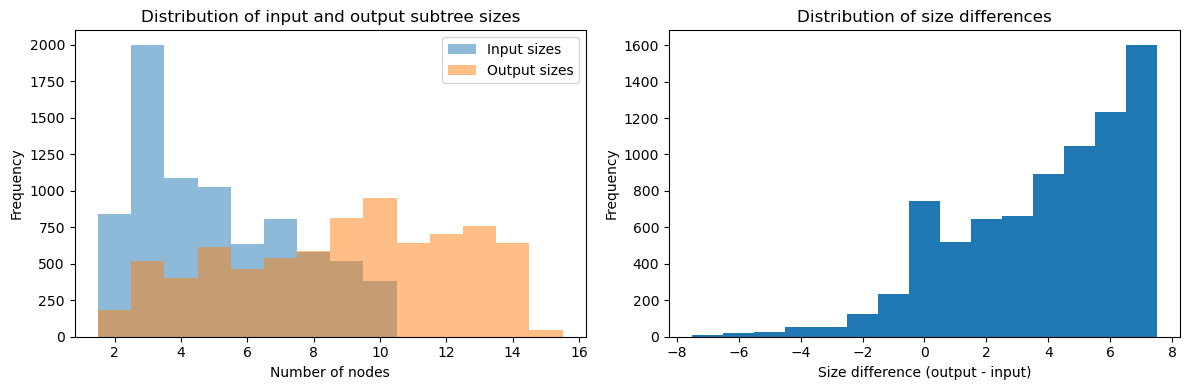

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


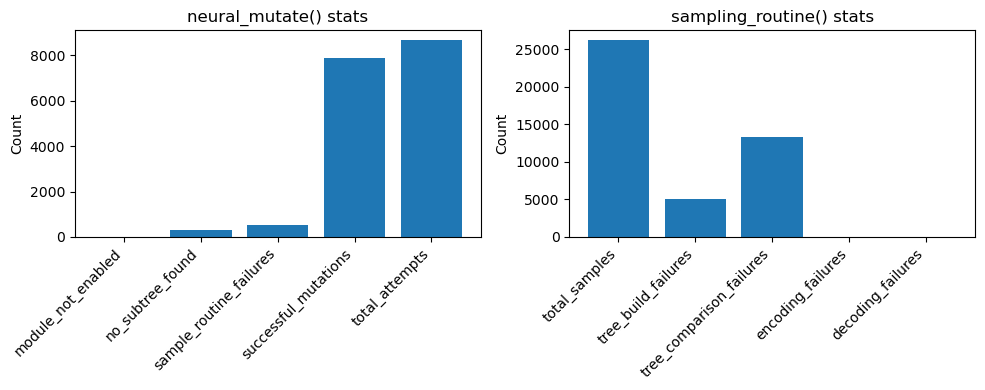

In [27]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Stats to show on right subplot
right_stats = ['total_samples', 'tree_build_failures', 'tree_comparison_failures', 'encoding_failures', 'decoding_failures']

# Left subplot with all other stats
left_stats = {k: v for k, v in count_stats.items() if k not in right_stats}
ax1.bar(left_stats.keys(), left_stats.values())
ax1.set_xticks(range(len(left_stats)))
ax1.set_xticklabels(left_stats.keys(), rotation=45, ha='right')
ax1.set_title('neural_mutate() stats')
ax1.set_ylabel('Count')

# Right subplot with selected stats
right_stats = {k: count_stats[k] for k in right_stats}
ax2.bar(right_stats.keys(), right_stats.values())
ax2.set_xticks(range(len(right_stats)))
ax2.set_xticklabels(right_stats.keys(), rotation=45, ha='right')
ax2.set_title('sampling_routine() stats')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
count_stats

{'decoding_failures': 0,
 'encoding_failures': 0,
 'module_not_enabled': 0,
 'no_subtree_found': 1394,
 'successful_mutations': 40855,
 'total_attempts': 52020,
 'tree_build_failures': 9797}

## Reading TensorBoard data

In [28]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

In [29]:
log_basedir = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/logs'
event_acc = EventAccumulator(os.path.join(log_basedir, 'no-noise_vanilla_0'))
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# # E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

{'images': [], 'audio': [], 'histograms': ['search/data/population/complexities'], 'scalars': ['search/data/summaries/min_loss', 'search/data/summaries/pareto_volume', 'search/data/num_evals', 'search/data/equations/complexity=6/loss', 'search/data/equations/complexity=10/loss', 'search/data/equations/complexity=8/loss', 'search/data/equations/complexity=7/loss', 'search/data/equations/complexity=5/loss', 'search/data/equations/complexity=3/loss', 'search/data/equations/complexity=1/loss', 'search/data/equations/complexity=14/loss', 'search/data/equations/complexity=20/loss', 'search/data/equations/complexity=18/loss', 'search/data/equations/complexity=16/loss', 'search/data/equations/complexity=12/loss', 'search/data/equations/complexity=25/loss', 'search/data/equations/complexity=22/loss', 'search/data/equations/complexity=23/loss', 'search/data/equations/complexity=19/loss', 'search/data/equations/complexity=26/loss', 'search/data/equations/complexity=24/loss', 'search/data/equation

In [64]:
event_acc.Scalars('search/data/summaries/min_loss')[0]


ScalarEvent(wall_time=1736525198.557605, step=1, value=14801625088.0)

In [67]:
import pandas as pd
losses = np.array([(e.wall_time, e.step, e.value) for e in event_acc.Scalars('search/data/summaries/min_loss')])

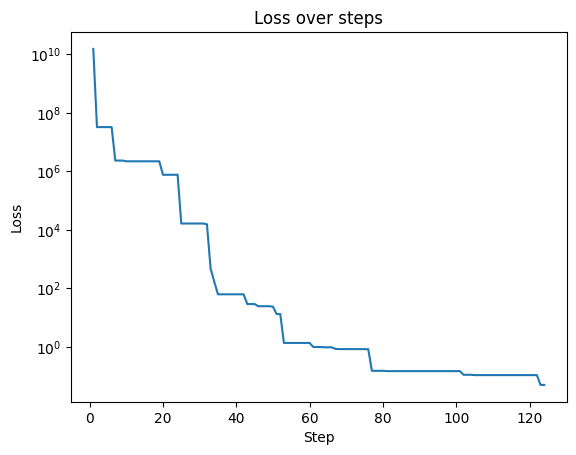

In [71]:
plt.plot(losses[:, 1], losses[:, 2])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over steps')
plt.yscale('log')
plt.show()


## Choosing operators

In [78]:
fpath = '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking/data/FeynmanEquations.csv'
df = pd.read_csv(fpath)
df.head()


,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1.0,f,exp(-theta**2/2)/sqrt(2*pi),1.0,theta,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2.0,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3.0,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4.0,d,sqrt((x2-x1)**2+(y2-y1)**2),4.0,x1,1.0,5.0,x2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5.0,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9.0,m1,1.0,2.0,m2,1.0,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


In [84]:
'log' in df.Formula.str.cat()

False

In [87]:
def find_remaining_ops(formulas):
    operators = ['exp', '*', '**', '/', '+', '-', 'sqrt', 'sin', 'cos', 'tan', 'sinh', 'cosh', 'tanh']
    
    # First count the known operators
    operator_counts = {}
    for formula in formulas.dropna():
        for op in operators:
            # For *, don't count occurrences that are part of **
            if op == '*':
                count = formula.count('*') - 2 * formula.count('**')
            else:
                count = formula.count(op)
            if count > 0:
                operator_counts[op] = operator_counts.get(op, 0) + count
    
    print("Known operator counts:")
    print(pd.Series(operator_counts).sort_values(ascending=False))
    
    # Then remove all known operators and see what's left
    print("\nRemainder after removing known operators:")
    remaining = formulas.copy()
    for op in operators:
        remaining = remaining.str.replace(op, ' ', regex=False)
    
    # Remove numbers, variables, spaces and parentheses
    remaining = remaining.str.replace(r'[0-9]', '', regex=True)
    remaining = remaining.str.replace(r'[a-zA-Z]', '', regex=True)
    remaining = remaining.str.replace(r'[\s\(\)]', '', regex=True)
    remaining = remaining.str.replace('.', '', regex=False)
    
    # Print unique remaining characters
    print("Unique remaining characters:", sorted(set(''.join(remaining.dropna()))))

find_remaining_ops(df.Formula)

Known operator counts:
*       255
/       138
**       87
-        45
+        30
sqrt     18
sin      11
cos      11
exp      10
tan       1
tanh      1
dtype: int64

Remainder after removing known operators:
Unique remaining characters: ['_']


In [86]:
df.Formula.dropna()

0                           exp(-theta**2/2)/sqrt(2*pi)
1           exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)
2     exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...
3                           sqrt((x2-x1)**2+(y2-y1)**2)
4            G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2)
                            ...                        
95                           (h/(2*pi))**2/(2*E_n*d**2)
96                                     2*pi*alpha/(n*d)
97                            beta*(1+alpha*cos(theta))
98    -m*q**4/(2*(4*pi*epsilon)**2*(h/(2*pi))**2)*(1...
99                                   -rho_c_0*q*A_vec/m
Name: Formula, Length: 100, dtype: object

## Reading whole benchmark's Tensorboard data

In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
from matplotlib import pyplot as plt

In [6]:
prefix = 'full4'
log_dir = '/mnt/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs/full4_'
matching_dirs = [d for d in os.listdir(log_dir) if d.startswith(prefix)]
len(matching_dirs)


200

In [7]:
def load_tensorboard_data(log_dir, prefixes=None, nsteps=None, early_stop_condition=1e-8, overall_prefix=None, by_type=False):
    # Handle different ways of specifying which runs to load
    if by_type:
        # Get all directories and filter by type
        all_dirs = os.listdir(log_dir)
        if overall_prefix:
            all_dirs = [d for d in all_dirs if d.startswith(overall_prefix)]
            
        # Create a dictionary to store runs by equation number for each type
        matching_dirs = {}
        if 'neural' in by_type:
            neural_dirs = [d for d in all_dirs if 'neural' in d]
            # Group by equation number
            for eq_num in range(1, 101):  # For equations 1-100
                eq_dirs = [d for d in neural_dirs if f'eq{eq_num}_' in d]
                if eq_dirs:
                    matching_dirs[f'neural_eq{eq_num}'] = eq_dirs
                    
        if 'vanilla' in by_type:
            vanilla_dirs = [d for d in all_dirs if 'vanilla' in d]
            # Group by equation number
            for eq_num in range(1, 101):  # For equations 1-100
                eq_dirs = [d for d in vanilla_dirs if f'eq{eq_num}_' in d]
                if eq_dirs:
                    matching_dirs[f'vanilla_eq{eq_num}'] = eq_dirs
    else:
        # Use specified prefixes
        if isinstance(prefixes, str):
            prefixes = [prefixes]
            
        matching_dirs = {}
        for prefix in prefixes:
            full_prefix = f"{overall_prefix}{prefix}" if overall_prefix else prefix
            matching_dirs[prefix] = [d for d in os.listdir(log_dir) if d.startswith(full_prefix)]
        
    all_losses = {}
    for prefix, dirs in matching_dirs.items():
        losses = []
        for dir_name in dirs:
            dir_path = os.path.join(log_dir, dir_name)
            event_acc = EventAccumulator(dir_path)
            event_acc.Reload()
            
            try:
                loss_events = event_acc.Scalars('search/data/summaries/min_loss')
                dir_losses = np.array([(e.wall_time, e.step, e.value) for e in loss_events])
                losses.append(dir_losses)
            except KeyError:
                print(f"No loss data found in {dir_name}")
                continue
                
        all_losses[prefix] = losses

    # If nsteps not provided, use max steps across all runs
    if nsteps is None:
        nsteps = max(max(x.shape[0] for x in losses) for losses in all_losses.values() if losses)

    # Pad all arrays to nsteps with early_stop_condition value
    for prefix, losses in all_losses.items():
        for i in range(len(losses)):
            current_steps = losses[i].shape[0]
            if current_steps < nsteps:
                # Create padding array with early_stop_condition value
                pad_length = nsteps - current_steps
                last_time = losses[i][-1, 0]  # Last timestamp
                time_increment = (last_time - losses[i][0, 0]) / current_steps  # Average time increment
                
                # Create padding timestamps continuing from last timestamp
                pad_times = np.array([last_time + (j+1)*time_increment for j in range(pad_length)])
                pad_steps = np.arange(current_steps, nsteps)
                pad_values = np.full(pad_length, early_stop_condition)
                
                pad_array = np.column_stack((pad_times, pad_steps, pad_values))
                losses[i] = np.vstack([losses[i], pad_array])

    # Get just the loss values and combine into single array for each prefix
    loss_arrays = {}
    for prefix, losses in all_losses.items():
        if not losses:  # Skip if no data for this prefix
            continue
        loss_array = np.zeros((losses[0].shape[0], len(losses)))
        for i in range(len(losses)):
            loss_array[:, i] = losses[i][:, 2]  # 3rd column is loss value
        loss_arrays[prefix] = loss_array
    
    return loss_arrays

def plot_losses(loss_arrays):
    # Plot losses over time with error margins
    plt.figure(figsize=(10, 6))

    # Generate enough colors using color map
    n_arrays = len(loss_arrays)
    color_map = plt.cm.get_cmap('tab20')  # Use tab20 colormap which has 20 distinct colors
    colors = [color_map(i/min(20, n_arrays)) for i in range(n_arrays)]

    for (prefix, losses), color in zip(loss_arrays.items(), colors):
        mean = np.mean(losses, axis=1)
        std = np.std(losses, axis=1)
        steps = np.arange(len(mean))
        
        plt.plot(steps, mean, label=prefix, color=color)
        plt.fill_between(steps,
                        mean - std,
                        mean + std,
                        alpha=0.3,
                        color=color)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Loss Over Time by Run Type')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
prefixes = [
    'eq20_neural_', 'eq30_neural_', 'eq40_neural_', 'eq50_neural_', 'eq60_neural_', 'eq70_neural_', 'eq80_neural_', 'eq90_neural_',
    'eq20_vanilla_', 'eq30_vanilla_', 'eq40_vanilla_', 'eq50_vanilla_', 'eq60_vanilla_', 'eq70_vanilla_', 'eq80_vanilla_', 'eq90_vanilla_'
]
log_basedir = '/mnt/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/round1/logs/full4_'
# losses = load_tensorboard_data(log_basedir, prefixes, nsteps=124, early_stop_condition=1e-8)
# Or using by_type:
losses = load_tensorboard_data(log_basedir, by_type=['neural', 'vanilla'], overall_prefix='full4_')
# plot_losses(losses)


/tmp/ipykernel_1594884/958137903.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20')  # Use tab20 colormap which has 20 distinct colors


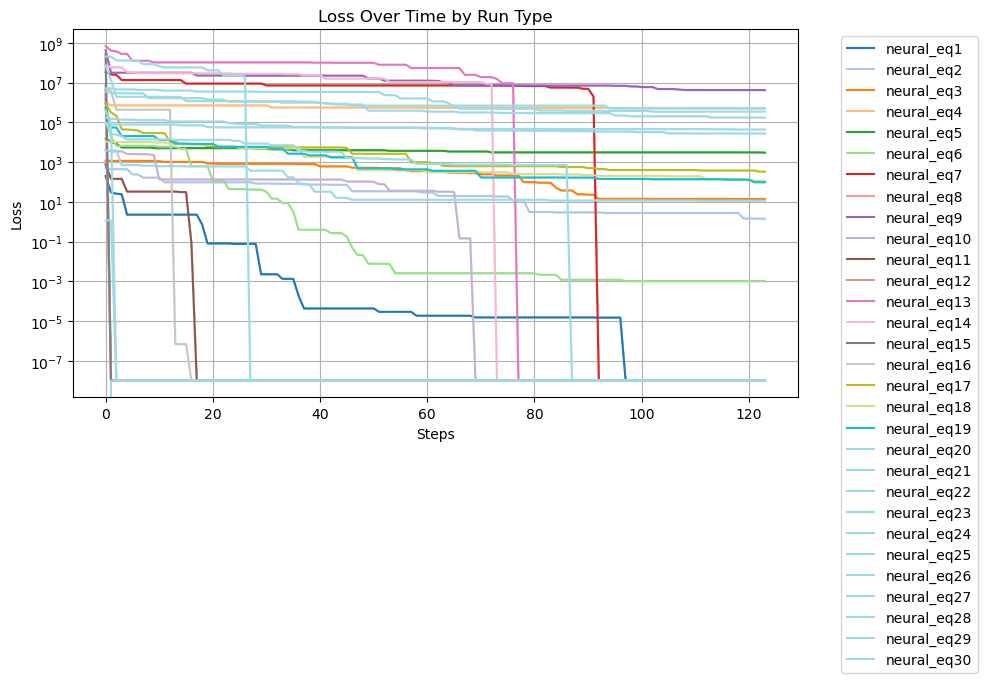

In [8]:
plot_losses({k: v for i, (k, v) in enumerate(losses.items()) if i < 30})

In [34]:
len(losses.keys())

200

In [9]:
def plot_threshold_counts(loss_arrays, threshold=1e-8):
    # Get max length across all arrays to standardize x-axis
    max_len = max(arr.shape[0] for arr in loss_arrays.values())
    steps = np.arange(max_len)
    
    # Group prefixes by type (neural vs vanilla)
    neural_losses = []
    vanilla_losses = []
    
    for prefix, losses in loss_arrays.items():
        if 'neural' in prefix:
            neural_losses.append(losses)
        elif 'vanilla' in prefix:
            vanilla_losses.append(losses)
    
    # Calculate counts below threshold at each timestep
    def get_counts_over_time(loss_list):
        if not loss_list:  # Handle empty lists
            return np.zeros(max_len)
            
        counts = np.zeros(max_len)
        for t in range(max_len):
            # Count how many equations have mean loss below threshold
            total = 0
            for losses in loss_list:
                if t < losses.shape[0]:  # Only count if we have data for this timestep
                    mean_loss = np.mean(losses[t,:])  # Take mean across runs
                    if mean_loss < threshold:
                        total += 1
            counts[t] = total
        return counts
    
    neural_counts = get_counts_over_time(neural_losses)
    vanilla_counts = get_counts_over_time(vanilla_losses)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    if len(neural_losses) > 0:
        plt.plot(steps, neural_counts, label='Neural', color='blue')
    if len(vanilla_losses) > 0:
        plt.plot(steps, vanilla_counts, label='Vanilla', color='red')
    
    plt.xlabel('Steps')
    plt.ylabel(f'Number of Equations with Mean Loss Below {threshold:0.0e}')
    plt.title('Count of Successful Equations Over Time')
    plt.ylim(0, 100)
    plt.xlim(0, 125)
    plt.legend()
    plt.grid(True)
    plt.show()


## Run 4
10k points, noise=0, with resampling

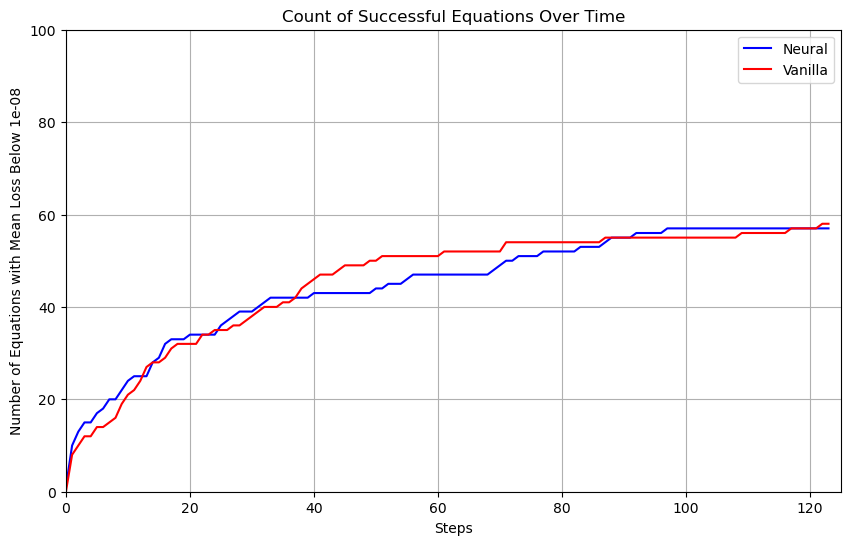

In [11]:
plot_threshold_counts(losses, threshold=1.1e-8)

## Run 2
100k points, noise=1e-3

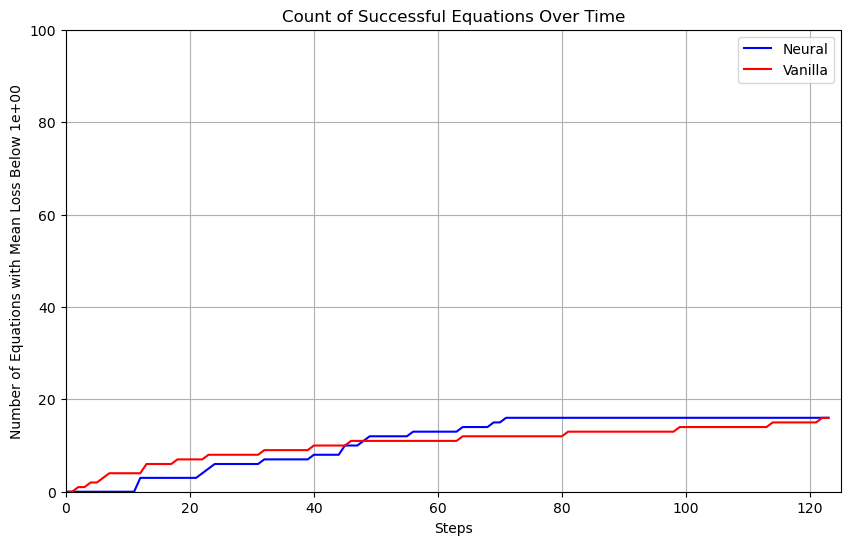

In [40]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e0)


## Run 1
10k points, no noise

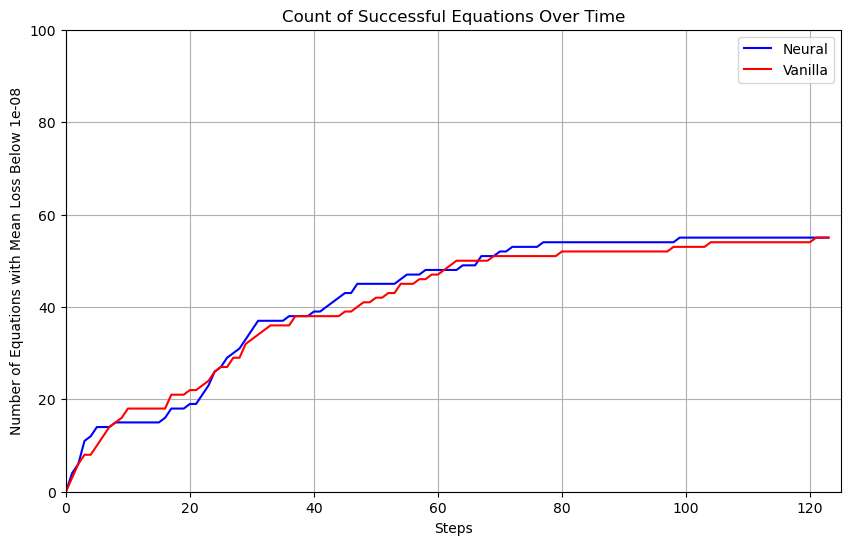

In [27]:
# Plot using the losses from previous cell
plot_threshold_counts(losses, threshold=1.1e-8)
